KMeans聚类完成：5个类别


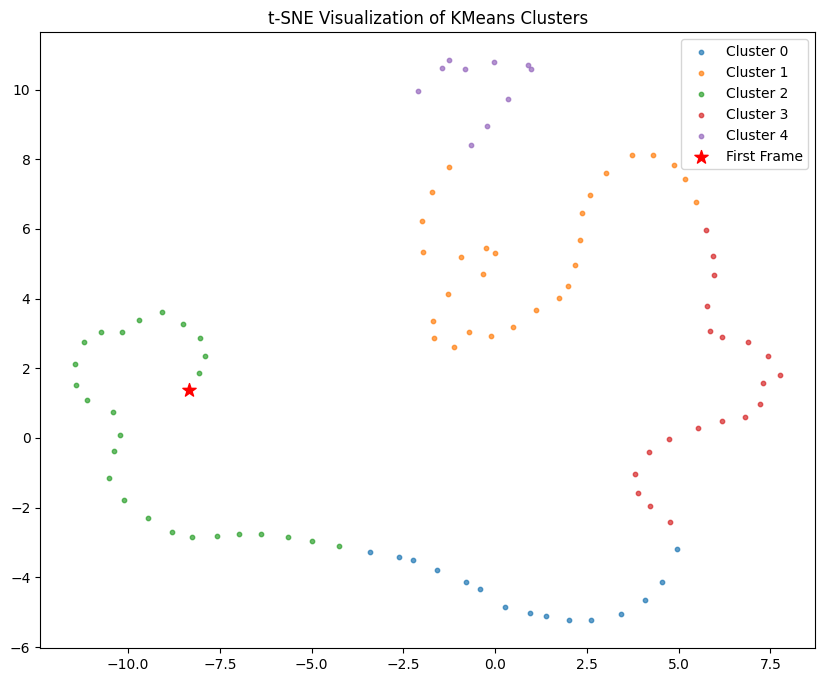

In [13]:
import os
import torch

import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

patch_tokens = torch.load('output/tmp/patch_tokens.pt')['x_norm_patchtokens']
# print(patch_tokens.shape) # [100, 1369, 1024]
N, P, C  = patch_tokens.shape
first_frame_idx = 0

tokens_np = patch_tokens.detach().cpu().numpy().reshape(N, P * C)
pca = PCA(n_components=64, random_state=42)
patch_pca = pca.fit_transform(tokens_np)

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)  # n_init=10避免局部最优
cluster_labels = kmeans.fit_predict(patch_pca)  # [N,]，每个样本的聚类标签
print(f"KMeans聚类完成：{n_clusters}个类别")

# --------------------------
# 4. t-SNE可视化聚类结果
# --------------------------
# t-SNE将PCA降维后的特征进一步降到2维（用于可视化）
tsne = TSNE(n_components=2, perplexity=30, random_state=42)  # perplexity根据样本量调整（5-50）
patch_tsne = tsne.fit_transform(patch_pca)  # [N, 2]

# 绘制散点图，用不同颜色表示不同聚类
plt.figure(figsize=(10, 8))
for i in range(n_clusters):
    mask = (cluster_labels == i)
    plt.scatter(patch_tsne[mask, 0], patch_tsne[mask, 1], 
                label=f"Cluster {i}", s=10, alpha=0.7)  # s=点大小，alpha=透明度
plt.scatter(patch_tsne[first_frame_idx, 0], patch_tsne[first_frame_idx, 1],
                color='red', s=100, marker='*', label="First Frame")
plt.legend()
plt.title("t-SNE Visualization of KMeans Clusters")
# plt.savefig(os.path.join(save_dir, "tsne_clusters.png"), dpi=300)
plt.show()
plt.close()

In [14]:
first_cluster_label = cluster_labels[first_frame_idx]  # 第一帧的聚类标签

# 找到所有与第一帧标签相同的frame索引（包括第一帧自身）
same_cluster_indices = np.where(cluster_labels == first_cluster_label)[0].tolist()
print(f"第一帧索引: {first_frame_idx}，所属聚类标签: {first_cluster_label}")
print(f"与第一帧同聚类的frame索引: {same_cluster_indices}")

第一帧索引: 0，所属聚类标签: 2
与第一帧同聚类的frame索引: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


In [15]:
from sklearn.metrics.pairwise import cosine_similarity

first_token = tokens_np[first_frame_idx:first_frame_idx+1]
similarities = cosine_similarity(tokens_np, first_token).squeeze()  # [S,]
# 按相似度从高到低排序，获取排序后的索引
sorted_indices = np.argsort(similarities)[::-1]  # 降序排列
sorted_similarities = similarities[sorted_indices]  # 排序后的相似度值

print(sorted_indices)
print(sorted_similarities)

[ 0  1  2  3  4  5  6  7  8 13 14 12 10  9 11 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 99 95 98 92 96 93 94 66 97 62 90 67 68 69 70 65 91
 63 64 71 89 31 61 32 72 33 88 74 86 85 59 87 60 58 82 81 73 75 76 37 40
 34 38 84 39 36 83 77 78 35 80 41 79 56 42 46 55 47 45 57 43 49 48 44 54
 51 50 52 53]
[1.0001475  0.973815   0.96351117 0.95946443 0.95401084 0.9482365
 0.9444994  0.94123226 0.9378963  0.936954   0.9365092  0.93549854
 0.93510664 0.93478596 0.9344769  0.9342781  0.93154454 0.9272894
 0.92289007 0.9181865  0.9150302  0.9145334  0.91294396 0.91153735
 0.91015965 0.90714735 0.9054658  0.9034573  0.90113056 0.89965665
 0.8994603  0.89910626 0.8989712  0.89893144 0.89885217 0.89853305
 0.8982182  0.8975935  0.8972503  0.8970762  0.89695954 0.89689815
 0.896827   0.89681876 0.8967232  0.89663684 0.8965271  0.89648575
 0.8962471  0.89572346 0.89568925 0.8955533  0.8954045  0.8952025
 0.8947957  0.8944752  0.89439297 0.8940563  0.8940305  0.8937379
 0.8936784  0.8936237  0.893

/data/xthuang/code/vggt/utils/dataset.py:56: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  data = np.loadtxt(filepath, delimiter=" ", dtype=np.str_, skiprows=skiprows)
/data/xthuang/code/vggt/utils/dataset.py:56: UserWarning: Input line 2 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If yo

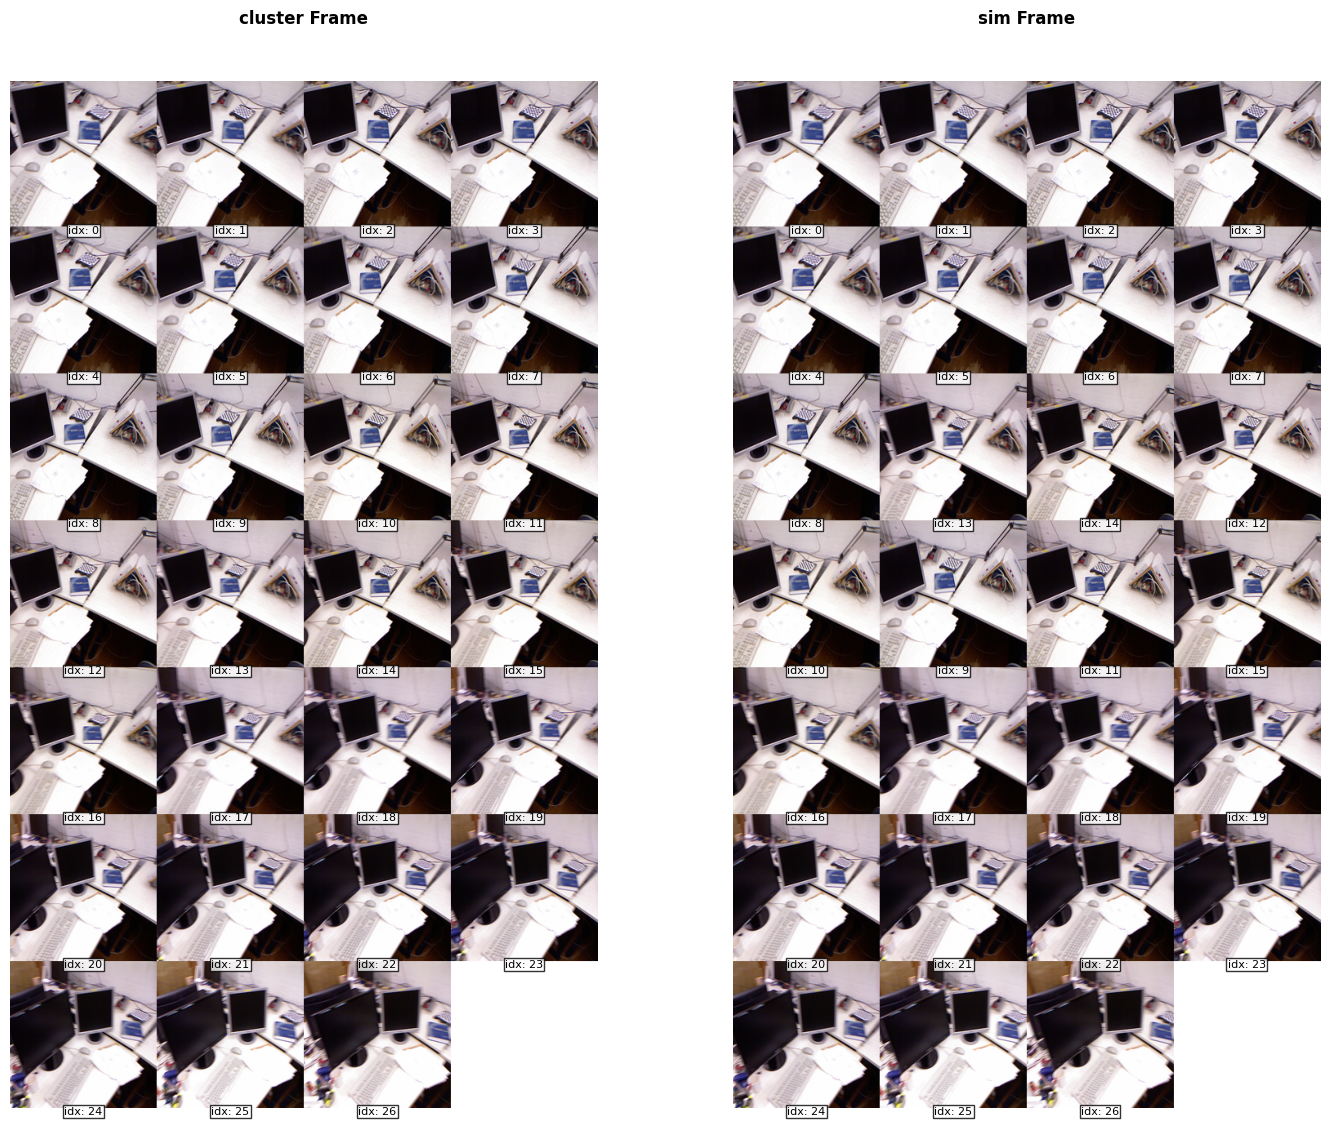

In [17]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import glob

from utils.config_utils import load_config
from utils.dataset import load_dataset


def plot_concatenated_images(image_paths: list, 
                             indices: list, 
                             ax: plt.Axes,  # 指定绘图对象（关键：支持多次调用叠加）
                             thumb_size=(200, 200), 
                             cols=5, 
                             group_label: str = None,  # 分组标签（区分不同调用的图片组）
                             label_pos: tuple = (0.5, 1.05)):  # 分组标签位置
    """
    多次调用该函数，在指定的matplotlib Axes上绘制图片缩略图拼接网格
    （支持同一画布绘制多组图片，如“同聚类组”“高相似度组”等）
    
    Args:
        image_paths: 所有图片的路径列表（与indices对应顺序）
        indices: 需要读取的图片索引列表（如与第一帧同聚类的frame索引）
        ax: matplotlib的Axes对象（指定绘图区域，实现多次调用叠加）
        thumb_size: 缩略图尺寸 (width, height)，默认(200, 200)
        cols: 拼接图的列数，默认5列
        group_label: 该组图片的标签（如“与第一帧同聚类”“相似度Top10”），默认不显示
        label_pos: 分组标签的相对位置 (x, y)，默认在网格上方居中
    """
    # 1. 筛选需要显示的图片路径，检查有效性
    selected_paths = [image_paths[i] for i in indices]
    num_images = len(selected_paths)
    if num_images == 0:
        raise ValueError("未找到需要显示的图片索引（indices为空）")
    
    # 2. 计算网格布局（行数=图片数/列数，向上取整）
    rows = (num_images + cols - 1) // cols
    canvas_width = cols * thumb_size[0]
    canvas_height = rows * thumb_size[1]
    
    # 3. 创建空白画布（白色背景，RGB格式）
    canvas = np.ones((canvas_height, canvas_width, 3), dtype=np.uint8) * 255  # 白色背景
    
    # 4. 逐个读取图片并绘制到画布
    for idx, (img_path, original_idx) in enumerate(zip(selected_paths, indices)):
        # 计算当前缩略图在网格中的坐标（左上角）
        row = idx // cols
        col = idx % cols
        x_start = col * thumb_size[0]
        y_start = row * thumb_size[1]
        x_end = x_start + thumb_size[0]
        y_end = y_start + thumb_size[1]
        
        # 读取并处理图片（支持PNG/JPG，处理透明通道）
        try:
            with Image.open(img_path) as img:
                img_rgb = img.convert("RGB")  # 转为RGB（去除透明通道）
                img_thumb = img_rgb.resize(thumb_size, Image.LANCZOS)  # 高质量缩放
                img_np = np.array(img_thumb)  # 转为numpy数组
                canvas[y_start:y_end, x_start:x_end] = img_np  # 绘制到画布
        except Exception as e:
            # 图片读取失败：显示红色警告块
            canvas[y_start:y_end, x_start:x_end] = [255, 0, 0]  # 红色填充
            print(f"警告：图片 {img_path} 读取失败，错误：{str(e)}")
        
        # 5. 在缩略图下方标注原始索引（如“idx: 5”）
        text_x = x_start + thumb_size[0] / 2  # 水平居中
        text_y = y_end + 10  # 缩略图底部下方10px
        ax.text(text_x, text_y, f"idx: {original_idx}", 
                ha="center", va="bottom", fontsize=8, color="black",
                bbox=dict(facecolor="white", alpha=0.8, pad=1))  # 白色半透明背景
    
    # 6. 绘制分组标签（如“与第一帧同聚类的frame”）
    if group_label is not None:
        ax.text(label_pos[0], label_pos[1], group_label, 
                ha="center", va="bottom", fontsize=12, fontweight="bold",
                transform=ax.transAxes)  # 使用Axes相对坐标，避免受画布尺寸影响
    
    # 7. 在指定的Axes上显示拼接后的画布
    ax.imshow(canvas)
    ax.axis("off")  # 隐藏坐标轴（只显示图片）
    
    # 8. 调整Axes的范围（确保画布完整显示）
    ax.set_xlim(0, canvas_width)
    ax.set_ylim(canvas_height + 30, 0)  # +30预留索引文本空间，y轴翻转（匹配图片坐标系）

config = load_config('/data/xthuang/code/vggt/configs/mono/tum/fr1_desk.yaml')
dataset = load_dataset('', '', config)
image_path_list = dataset.color_paths[:100]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 12))  # 画布大小(宽, 高)
plot_concatenated_images(
    image_paths=image_path_list,
    indices=same_cluster_indices,
    ax=ax1,  # 绘制到第一个子图（上方）
    thumb_size=(180, 180),  # 缩略图尺寸
    cols=4,  # 每行3张图
    group_label="cluster Frame",  # 分组标签
    label_pos=(0.5, 1.05)  # 标签在子图上方居中
)

# --------------------------
# 4. 第二次调用：绘制“高相似度组”图片
# --------------------------
plot_concatenated_images(
    image_paths=image_path_list,
    indices=sorted_indices[:len(same_cluster_indices)],
    ax=ax2,  # 绘制到第二个子图（下方）
    thumb_size=(180, 180),
    cols=4,
    group_label="sim Frame",
    label_pos=(0.5, 1.05)
)

plt.tight_layout(pad=3.0)  # 子图间间距3.0，避免标签重叠
plt.savefig("output/tmp/multi_group_images.png", dpi=300, bbox_inches="tight")  # 保存图片
plt.show()  # 显示图片